<a href="https://colab.research.google.com/github/Jectrianama/GCCE_TEST/blob/main/GoldStandard1/golds_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Subclassing for GS

In [34]:
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score, mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import numpy as np

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def onehot_encode(df, columns):
    df = df.copy()
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

def preprocess_inputs(df):
    df = df.copy()
    
    # Encode label values as numbers
    df['V10'] = df['V10'].replace({'negative': 0, 'positive': 1})
    
    # One-hot encode board space columns
    df = onehot_encode(
        df,
        columns=['V' + str(i) for i in range(1, 10)]
    )
    
    # Split df into X and y
    y = df['V10'].copy()
    X = df.drop('V10', axis=1).copy()
    
    # Train-test split
   # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X, y



def evaluation_metrics(y_true, y_pred, print_result=True):
    acc = 0
    auc = 0
    auc_sk = 0
    #mi = 0
    nmi = 0
    #ami = 0
    bacc = 0
    
    # Accuracy
    #report = classification_report(y_pred.argmax(axis=1), y_true.ravel(), output_dict=True)
    acc = accuracy_score( y_true.ravel(), y_pred.argmax(axis=1))  #report['accuracy']
    
    # Balanced accuracy
    bacc = balanced_accuracy_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze(), adjusted=True)
    
   # # Mutual Information
   # mi = mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Normalized Mutual Information
    nmi = normalized_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # Adjusted Mutual Information
    #ami = adjusted_mutual_info_score(y_true.squeeze(), y_pred.argmax(axis=1).squeeze())
    
    # AUC (Tensorflow)
    auc_metric = tf.keras.metrics.AUC(from_logits=True)
    auc_metric.update_state(y_true, y_pred.argmax(axis=1).astype('float'))
    auc = auc_metric.result().numpy()
    auc_metric.reset_states()
    
    # AUC (scikit-learn)
    auc_sk = roc_auc_score(ook(y_true), y_pred)
    
    if print_result:
        print("Accuracy: {:.4f}".format(acc))
        print("Balanced Accuracy: {:.4f}".format(bacc))
        #print("Mutual Information: {:.4f}".format(mi))
        print("Normalized Mutual Information: {:.4f}".format(nmi))
        #print("Adjusted Mutual Information: {:.4f}".format(ami))
        print("AUC (Tensorflow): {:.4f}".format(auc))
        print("AUC (scikit-learn): {:.4f}".format(auc_sk))
    
    return acc, auc, auc_sk, nmi, bacc   # mi, , ami




In [35]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_GCCE(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1, neurons=4):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q
        self.neurons = neurons

    
 
    def GCCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)

        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))

 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

 
    def fit(self, X, Y):

        def scheduler1(step = 10, ratio = 1.2):
          def scheduler(epoch, lr):
            if epoch % step == 0 and epoch>1:
              return lr/ratio
            else:
              return lr
          return scheduler
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        initializer = tf.keras.initializers.GlorotNormal(seed=100)

        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, clipnorm=1.0)
        else:
            opt=self.optimizer

        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X.shape[1]), name='entrada')
        #capas densas
        h1 = tf.keras.layers.Dense(int(P*self.neurons*(self.K+self.R)),activation='selu',name='h1',bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l)#argumento de entrada
        h2 = tf.keras.layers.Dense(int(P*(self.K+self.R)),activation='selu',name='h2', bias_initializer='zeros', kernel_initializer=initializer,
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
        #capa de salida
        output = tf.keras.layers.Dense(self.K,activation="softmax",name='output', bias_initializer='zeros', kernel_initializer=initializer,
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(dout)
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=opt,metrics="accuracy")
         
        callback1 = tf.keras.callbacks.TerminateOnNaN()
        callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio = 1))
        #callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)
        callback3 = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-2,
                                                 patience=15, verbose=0, mode="auto",
                                                 baseline=None, restore_best_weights=True)
               
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split, callbacks = [callback1, callback2],   #
                                      batch_size=self.batch_size,verbose=self.verbose)
 
        return self
 
  
   
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q, 'neurons': self.neurons
                }

  
        return self


In [36]:
#cargar datos desde drive acceso libre
FILEID = "1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW"
#https://drive.google.com/file/d/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MADatasets.zip && rm -rf /tmp/cookies.txt
!unzip -o MADatasets.zip
!dir

--2023-02-13 20:27:24--  https://docs.google.com/uc?export=download&confirm=t&id=1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW
Resolving docs.google.com (docs.google.com)... 142.251.18.139, 142.251.18.100, 142.251.18.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.18.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jauvhd1asdu8a2jd9orj21gapsfrid38/1676319975000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=d58a772e-3ba0-4413-b035-f4946da72eb4 [following]
--2023-02-13 20:27:24--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/jauvhd1asdu8a2jd9orj21gapsfrid38/1676319975000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=d58a772e-3ba0-4413-b035-f4946da72eb4
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 108.177.119.132,

# Load Data

In [37]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
database = 'Segmentation' #['bupa1', 'breast-cancer-wisconsin1','pima-indians-diabetes1', 'ionosphere1', 'tic-tac-toe1', 'iris1', 'wine1', 'segmentation1']


path_ = 'MADatasets/'+ database+ '.mat' 
Xdata = sio.loadmat(path_)
Xdata.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Y', 'iAnn', 'Exp', 'idxtr', 'idxte'])

In [38]:
X = Xdata['X']
# Xte = Xdata['Xte']
Y = Xdata['Y']
t = Xdata['y'].reshape(-1)
print('X',X.shape,'t',t.shape,'Y',Y.shape)
 

X (2310, 18) t (2310,) Y (2310, 5)


In [39]:
t 

array([1, 1, 1, ..., 7, 7, 7], dtype=uint8)

In [40]:
t = t - 1

# Split data

In [41]:
import numpy.matlib
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
Ns = 1
ss = ShuffleSplit(n_splits=Ns, test_size=0.3,random_state =123)
for train_index, test_index in ss.split(X):
    print(test_index)
    X_train, X_test,Y_train,Y_test = X[train_index,:], X[test_index,:],Y[train_index,:], Y[test_index,:]
    Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
print(X_train.shape, Y_train.shape, Y_true_train.shape)

[2031  671 1207 1236  343 1158  822  558   18 1644 2044 2257 1440 1290
 1758 2263 1422 1633   33  689  206 1380 2291   25 1652  961  279 2076
 1777  995 1424  493  132  224 1278 1162 1121 1496 2303  327 1233 1631
  417 1036  977 1708 2248 1204  803  711  856   50 2249  511 1567 1068
 1725   12 2097  704 1667 1253 2041  965 1055 1237 2071 2165 1106 1873
 2153  141 1860 1033  266 1661 1730  978 1614  813 1148   45 2045 2030
 1181 1209  746  421 2197 1331 2034  875 1049 1404 1137 1851  683  809
  515 1195 1256 2102 1018  967  476 1337 2170 1982  615 2177  388 1548
 1744  110  835 2100 1126 1109  935 1802 1977 1797  668  820  190 1707
 1542 1541  289  784 1446 1979 1903  326  292  420  798  239 1831  310
  449  708 1201 2176 1449   72  982  800 2213  403  381  148 1531  601
  466 2152 1676  351 1269 1412  728 1143  116 1790 1843 1818  658 1525
 2308 1333  735 1059  777 1637 2243 1686  409 1697 1978 1516 1217 2304
 1757  701 2266  120  680 1728  906  988  670 2179  375 1373 1913 1182
   58 

# Apply MinMaxScaler

In [42]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Testing the Class 


iteration: 0


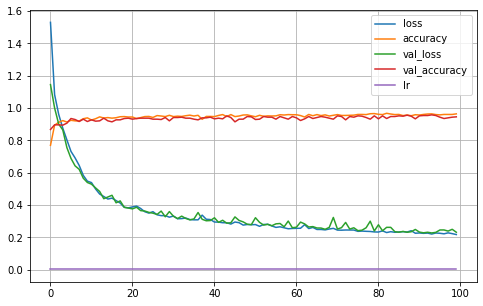

22/22 [==============================] - 0s 2ms/step
Accuracy: 0.9524
Balanced Accuracy: 0.9453
Normalized Mutual Information: 0.9071
AUC (Tensorflow): 1.0000
AUC (scikit-learn): 0.9961
iteration: 1


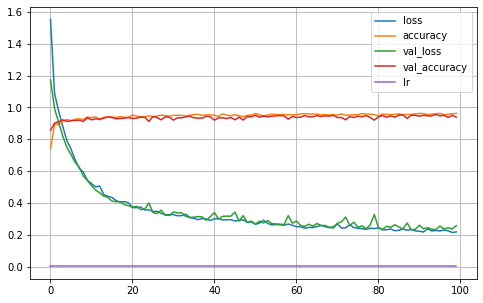

Exception ignored in: <function UniquePtr.__del__ at 0x7f3bc16d01f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/tensorflow/python/framework/c_api_util.py", line 71, in __del__
    obj = self._obj
AttributeError: _obj


22/22 [==============================] - 0s 2ms/step
Accuracy: 0.9423
Balanced Accuracy: 0.9339
Normalized Mutual Information: 0.8956
AUC (Tensorflow): 0.9956
AUC (scikit-learn): 0.9948
iteration: 2


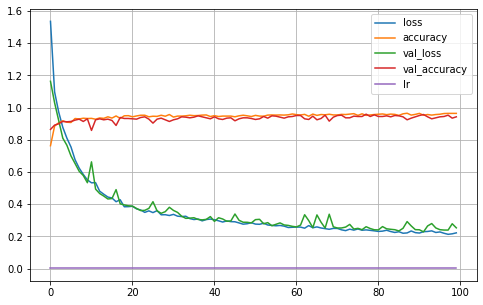

22/22 [==============================] - 0s 2ms/step
Accuracy: 0.9495
Balanced Accuracy: 0.9423
Normalized Mutual Information: 0.9118
AUC (Tensorflow): 1.0000
AUC (scikit-learn): 0.9953
iteration: 3


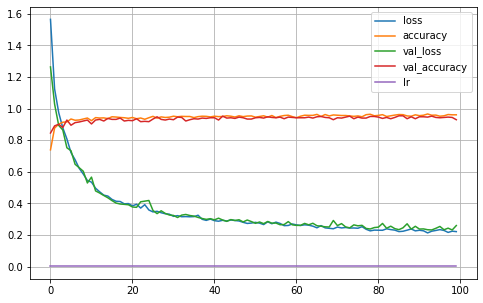

22/22 [==============================] - 0s 3ms/step
Accuracy: 0.9452
Balanced Accuracy: 0.9375
Normalized Mutual Information: 0.9040
AUC (Tensorflow): 1.0000
AUC (scikit-learn): 0.9956
iteration: 4


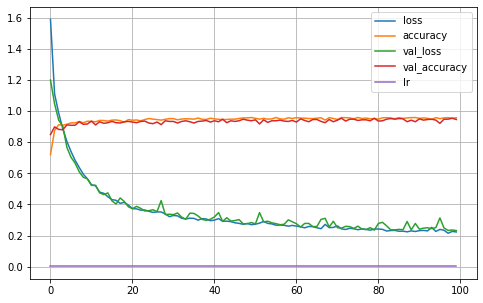

22/22 [==============================] - 0s 2ms/step
Accuracy: 0.9466
Balanced Accuracy: 0.9386
Normalized Mutual Information: 0.8995
AUC (Tensorflow): 1.0000
AUC (scikit-learn): 0.9958
iteration: 5


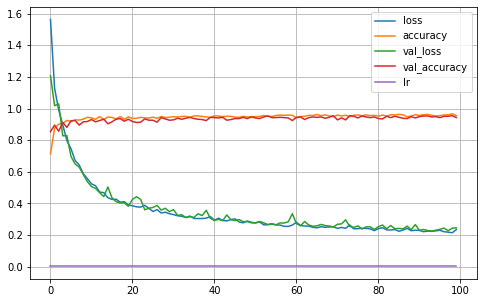

22/22 [==============================] - 0s 2ms/step
Accuracy: 0.9538
Balanced Accuracy: 0.9464
Normalized Mutual Information: 0.9109
AUC (Tensorflow): 1.0000
AUC (scikit-learn): 0.9958
iteration: 6


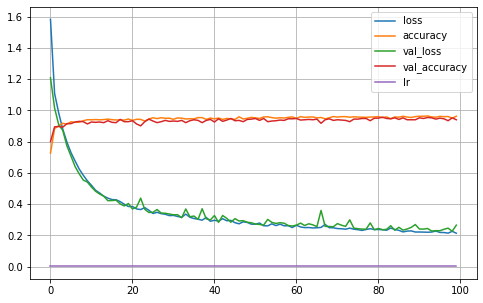

22/22 [==============================] - 0s 2ms/step
Accuracy: 0.9394
Balanced Accuracy: 0.9308
Normalized Mutual Information: 0.8971
AUC (Tensorflow): 0.9939
AUC (scikit-learn): 0.9944
iteration: 7


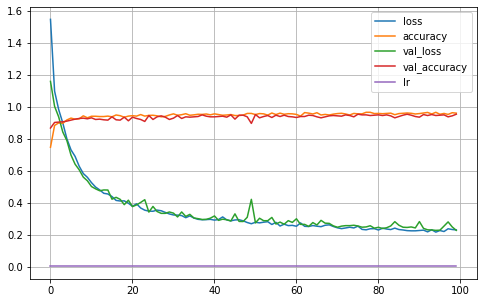

22/22 [==============================] - 0s 2ms/step
Accuracy: 0.9336
Balanced Accuracy: 0.9229
Normalized Mutual Information: 0.8876
AUC (Tensorflow): 0.9992
AUC (scikit-learn): 0.9957
iteration: 8


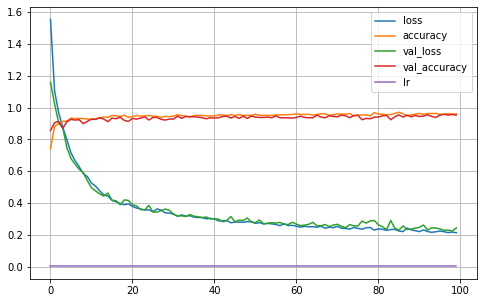

22/22 [==============================] - 0s 2ms/step
Accuracy: 0.9481
Balanced Accuracy: 0.9407
Normalized Mutual Information: 0.9044
AUC (Tensorflow): 0.9957
AUC (scikit-learn): 0.9954
iteration: 9


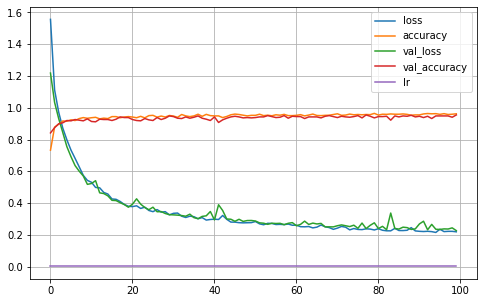

22/22 [==============================] - 0s 3ms/step
Accuracy: 0.9610
Balanced Accuracy: 0.9555
Normalized Mutual Information: 0.9259
AUC (Tensorflow): 1.0000
AUC (scikit-learn): 0.9959


In [43]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
import pandas as pd
l1 =0.0001
NUM_RUNS =10
custom_loss = "GOLD"


results = []
for i in range(NUM_RUNS):

    print("iteration: " + str(i))
   
    MA = Keras_MA_GCCE(epochs=100,batch_size=32,R=5, K=len(np.unique(Y_true_train)), dropout=0.2, learning_rate= 0.001,optimizer='Adam', 
                l1_param=l1,  validation_split=0.30, verbose=0, q=0.1)
    
    MA.fit(X_train, Y_true_train)
    MA.plot_history()
  
    # Generate the predictions for the current run
    pred_2 = MA.predict(X_test)
     
    acc, auc, auc_sk,  nmi,  bacc = evaluation_metrics(Y_true_test,  pred_2, print_result=True)  # mi, ami,
    
    # Save the results for the current run to the list of dictionaries
    results.append({
        #'run': i,
        'accuracy': acc,
        'balanced_accuracy': bacc,
       # 'mutual_information': mi,
        'normalized_mutual_information': nmi,
     #   'adjusted_mutual_information': ami,
        'auc_tensorflow': auc,
        'auc_scikit_learn': auc_sk,
    })
    
# Convert the list of dictionaries to a DataFrame
df = np.round(pd.DataFrame(results)*100, 2)

# Calculate the mean and standard deviation of each metric
mean = np.round(df.mean(),2)
std = np.round(df.std(),2)  


In [44]:
# from sklearn.metrics import classification_report, balanced_accuracy_score
# from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
# l1 =0.0001
# NUM_RUNS =10
# ACC = np.zeros(NUM_RUNS)
# AUC = np.zeros(NUM_RUNS)
# MI = np.zeros(NUM_RUNS)
# NMI = np.zeros(NUM_RUNS)
# AMI = np.zeros(NUM_RUNS)
# BACC = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS): #10
#     print("iteration: " + str(i))
   
#     MA = Keras_MA_GCCE(epochs=100,batch_size=32,R=5, K=len(np.unique(Y_true_train)), dropout=0.2, learning_rate= 0.001,optimizer='Adam', 
#                 l1_param=l1,  validation_split=0.30, verbose=0, q=0.1)
    
#     MA.fit(X_train,  Y_true_train)
#     MA.plot_history()
  
#     #Accuracy
#     pred_2 = MA.predict(X_test)
 
#     report = classification_report( pred_2.argmax(axis=1),Y_true_test.ravel(),output_dict=True)
#     ACC[i] = report['accuracy']
#     print("Validation ACC: %.4f" % (float(ACC[i])))


#     # balanced. Accurcy
#     BACC[i] = balanced_accuracy_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze(), adjusted=True)
#     print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))

#     #MI
    
#     MI[i] = mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
#     print("Validation MI: %.4f" % (float(MI[i]),))
#     NMI[i] = normalized_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
#     print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
#     AMI[i]= adjusted_mutual_info_score(Y_true_test.squeeze(), pred_2.argmax(axis=1).squeeze())
#     print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))


#     #AUC
#     val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)  
#    # val_logits =MA.predict(X_test) # model(X_test, training=False)
#     # tf.print(y_batch_val)
#     val_AUC_metric.update_state(Y_true_test, pred_2.argmax(axis=1).astype('float'))

#     val_AUC = val_AUC_metric.result()
#     val_AUC_metric.reset_states()
#     val_AUC = val_AUC.numpy()
#     print("Validation aUc: %.4f" % (float(val_AUC),))
#     AUC[i] = val_AUC
    

In [45]:
df

,accuracy,balanced_accuracy,normalized_mutual_information,auc_tensorflow,auc_scikit_learn
0,95.24,94.53,90.71,100.000000,99.61
1,94.23,93.39,89.56,99.559998,99.48
2,94.95,94.23,91.18,100.000000,99.53
3,94.52,93.75,90.40,100.000000,99.56
4,94.66,93.86,89.95,100.000000,99.58
5,95.38,94.64,91.09,100.000000,99.58
6,93.94,93.08,89.71,99.389999,99.44
7,93.36,92.29,88.76,99.919998,99.57
8,94.81,94.07,90.44,99.570000,99.54
9,96.10,95.55,92.59,100.000000,99.59


In [46]:
mean

accuracy                         94.72
balanced_accuracy                93.94
normalized_mutual_information    90.44
auc_tensorflow                   99.84
auc_scikit_learn                 99.55
dtype: float64

In [47]:
std

accuracy                         0.78
balanced_accuracy                0.90
normalized_mutual_information    1.06
auc_tensorflow                   0.24
auc_scikit_learn                 0.05
dtype: float64

In [48]:
result_df = pd.concat([mean.rename('Mean'), std.rename('Std')], axis=1)

In [49]:
result_df

,Mean,Std
accuracy,94.72,0.78
balanced_accuracy,93.94,0.90
normalized_mutual_information,90.44,1.06
auc_tensorflow,99.84,0.24
auc_scikit_learn,99.55,0.05


In [50]:
# Save the DataFrame to an excel file
result_df.to_excel(database + custom_loss + ".xlsx")